## set up dependencies and util functions

In [57]:
import numpy as np
from dm_control import mujoco
import mediapy as media
import matplotlib.pyplot as plt

""

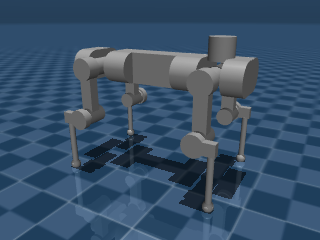

In [56]:
physics = mujoco.Physics.from_xml_path("../anymal_c_simple_description/scene.xml")
nv = physics.model.nv
nu = physics.model.nu
pixels = physics.render()
media.show_image(pixels)

In [48]:
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def generate_video(physics, control, start_key=None, duration=1, framerate=30):
    frames = []
    physics.reset(start_key)
    while physics.data.time < duration:
        physics.step()
        control(physics)
        if len(frames) < (physics.data.time) * framerate:
            pixels = physics.render()
            frames.append(pixels)
    return media.show_video(frames, fps=framerate)


def generate_from_qpos(physics, times, qposes, framerate=30):
    # assume times are uniform
    frames = []
    for t, qpos in zip(times, qposes):
        physics.data.qpos = qpos
        physics.data.qvel[:] = 0
        physics.step()
        pixels = physics.render()
        frames.append(pixels)
    return media.show_video(frames, fps=framerate)    

In [49]:
def simple_control(physics):
    physics.data.ctrl[:] = np.random.randn(*physics.data.ctrl.shape)

generate_video(physics, simple_control, duration=10)

In [5]:
conf0 = physics.model.qpos0
conf1 = conf0.copy()
conf1[0] += 1
u = np.linspace(0, 1, 100)
qpos_series = (1-u)[:, None] * conf0[None, :] + u[:, None] * conf1[None, :]

generate_from_qpos(physics, u, qpos_series)

In [6]:
# be careful. q has one extra element (idk what it is) q[6] is the extra...
# the joint_ids are compatible with nv not nq
print(physics.model.qpos0.shape)
print(physics.data.qvel.shape)

(19,)
(18,)


In [7]:
joint_names = [physics.model.joint(i).name for i in range(physics.model.njnt) if physics.model.joint(i).name]
joint_ids = [physics.model.joint(name).dofadr[0] for name in joint_names]

contact_site_names = ["foot1", "foot2", "foot3", "foot4"]
contact_site_ids = [physics.model.site(name) for name in contact_site_names]

In [8]:
physics.model.body('base')

<_MjModelBodyViews
  dofadr: array([0], dtype=int32)
  dofnum: array([6], dtype=int32)
  geomadr: array([1], dtype=int32)
  geomnum: array([38], dtype=int32)
  id: 1
  inertia: array([0.639559, 0.624031, 0.217374])
  invweight0: array([0.02805148, 0.95728878])
  ipos: array([0.0025   , 0.       , 0.0502071])
  iquat: array([0.5, 0.5, 0.5, 0.5])
  jntadr: array([0], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([19.2035])
  mocapid: array([-1], dtype=int32)
  name: 'base'
  parentid: array([0], dtype=int32)
  pos: array([0.  , 0.  , 0.62])
  quat: array([0., 0., 0., 1.])
  rootid: array([1], dtype=int32)
  sameframe: array([0], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([44.96518])
  user: array([], dtype=float64)
  weldid: array([1], dtype=int32)
>

In [10]:
physics.model.body('base').subtreemass
physics.model.body('base').inertia

array([0.639559, 0.624031, 0.217374])

In [15]:
import casadi as ca

casadi_M_func = ca.Function.load('../kino_dynamics_gen/casadi_functions/M.func')

casadi_M_func(physics.model.qpos0)

DM(
[[52.1349, 0, 0, 0, -3.65961, 0.0046989, 0, -0.969693, -0.0474618, 2.0082e-13, -0.969693, -0.0474618, 0, -0.969693, -0.0474618, 2.0082e-13, -0.969693, -0.0474618], 
 [0, 52.1349, 0, 3.65961, 0, -0.469283, 0.970975, 4.74823e-12, 2.32404e-13, 0.970975, 4.77511e-12, 2.33717e-13, 0.970975, -4.74824e-12, -2.32404e-13, 0.970975, -4.72137e-12, -2.31087e-13], 
 [0, 0, 52.1349, -0.0046989, 0.469283, 0, 0.511933, -0.0358996, -0.0360424, 0.511933, 0.0361852, 0.0360424, -0.511933, -0.0361852, -0.0360424, -0.511933, 0.0358996, 0.0360424], 
 [0, 3.65961, -0.0046989, 2.39682, 0.00897791, 0.0629241, 0.42165, -0.0105405, -0.0105275, 0.42165, 0.0105143, 0.0105275, 0.42165, 0.0105143, 0.0105275, 0.42165, -0.0105405, -0.0105275], 
 [-3.65961, 0, 0.469283, 0.00897791, 6.4525, -0.000123817, -0.190888, 0.31891, 0.0426918, 0.190748, 0.319013, 0.0426918, 0.190748, 0.319013, 0.0426918, -0.190888, 0.31891, 0.0426918], 
 [0.0046989, -0.469283, 0, 0.0629241, -0.000123817, 6.26712, 0.364124, 0.232244, 0.0139108

In [23]:
MM[0, 0]

44.965180000000004

In [22]:
physics.reset()
physics.step()
MM = np.zeros((physics.model.nv, physics.model.nv))
mujoco.mj_fullM(physics.model._model, MM, physics.data.qM)
MM.round(3)[-1, :]

array([ 0.047, -0.   ,  0.036, -0.011,  0.043, -0.014,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.007,
        0.03 ,  0.016])

In [203]:
MM[:3, 3:6].round(2)

array([[ 0.  ,  2.92,  0.  ],
       [-2.92,  0.  , -0.05],
       [ 0.  , -0.05,  0.  ]])

## First round optimization

In [7]:
physics.data.iner

AttributeError: 'MjData' object has no attribute 'iner'

In [45]:
import casadi as ca

def formulate_optimization(physics, N_traj=21):
    opti = ca.Opti()
    
    X = opti.variable(N_traj, 8)
    q = X[:, :4]
    dq = X[:, 4:]
    f_contact = [opti.variable(3, N_traj-1) for foot in feet]
    
    # ignore q limits and qd limits for now as we don't have them in the model
    mu = opti.parameter()
    mass = opti.parameter()
    Ib_inv = opti.parameter(3, 1)

    q_init = opti.parameter(4, 1)
    q_final = opti.parameter(4, 1)
    
    # initial conditions
    opti.subject_to(q_init == q[0, :])
    opti.subject_to(q_final == q[-1, :])

    # dynamics constraint
    

Opti(Opti {
  instance #0
  #variables: 0 (nx = 0)
  #parameters: 0 (np = 0)
  #constraints: 0 (ng = 0)
  CasADi solver needs updating.
})